TSNE Check Embeddings Performance

提取向量和家族資訊...
原始資料筆數：17043
篩選後資料筆數：6433


Processing Gpickle files: 100%|██████████| 6433/6433 [00:03<00:00, 1804.99it/s]


總共載入 6391 個向量
數據量較大，進行抽樣以加速 t-SNE 運算。
執行 t-SNE 並創建視覺化...


/tmp/ipykernel_3520074/228253094.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  family_colors = plt.cm.get_cmap('tab10', len(set(families)))


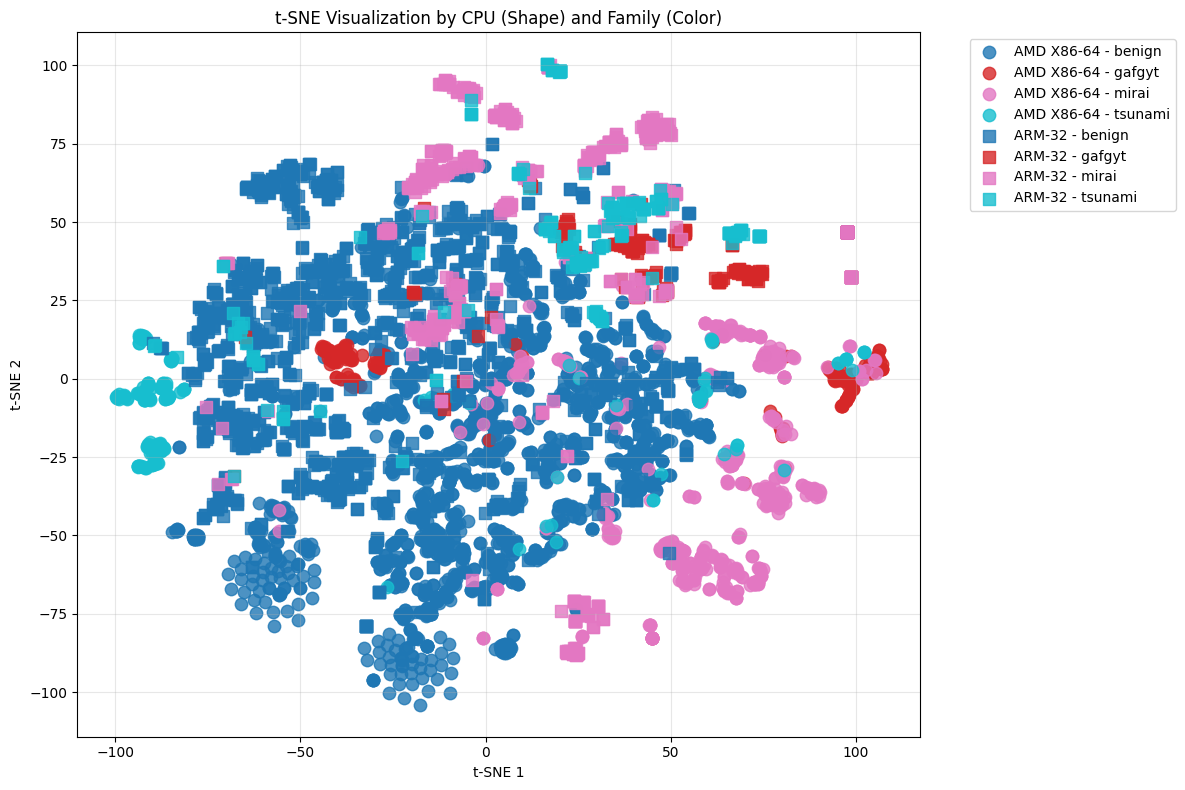


Numerical Analysis: Cluster Centroids & Distances

Cluster Centroid Coordinates (t-SNE 2D):
                      t-SNE 1    t-SNE 2
AMD X86-64-benign   -1.120000 -29.059999
AMD X86-64-gafgyt   30.000000   1.060000
AMD X86-64-mirai    60.250000 -29.490000
AMD X86-64-tsunami -51.939999  -8.660000
ARM-32-benign      -31.290001  11.510000
ARM-32-gafgyt       44.119999  38.400002
ARM-32-mirai        14.060000  42.770000
ARM-32-tsunami      19.770000  44.110001

Euclidean Distance Between Clusters:
                    AMD X86-64-benign  AMD X86-64-gafgyt  AMD X86-64-mirai  \
AMD X86-64-benign            0.000000          43.299999         61.369999   
AMD X86-64-gafgyt           43.299999           0.000000         43.000000   
AMD X86-64-mirai            61.369999          43.000000          0.000000   
AMD X86-64-tsunami          54.759998          82.510002        114.110001   
ARM-32-benign               50.560001          62.180000        100.309998   
ARM-32-gafgyt               81.2

In [1]:
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from typing import List, Union
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# 忽略 tqdm 的 FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def extract_vectors_from_gpickle(csv_file_path: Union[str, Path], root_dir: Union[str, Path], cpu_filter: List[str]):
    """
    從 CSV 讀取檔案資訊，並從 .gpickle 檔案中提取向量
    """
    root_path = Path(root_dir)
    df = pd.read_csv(csv_file_path)
    
    filtered_df = df[df['CPU'].isin(cpu_filter)]
    
    print(f"原始資料筆數：{len(df)}")
    print(f"篩選後資料筆數：{len(filtered_df)}")
    
    vectors = []
    cpus = []
    families = []
    
    for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Processing Gpickle files"):
        file_name = row['file_name']
        cpu = row['CPU']
        family = row['family']
        
        prefix = file_name[:2]
        path = root_path / prefix / f"{file_name}.gpickle"
        
        if path.exists():
            try:
                with open(path, "rb") as fp:
                    data = pickle.load(fp)
                
                if 'node_embeddings' in data and data['node_embeddings']:
                    node_embeddings = data['node_embeddings']
                    node_vectors = [np.array(emb) for emb in node_embeddings.values() if len(emb) == 256]
                    
                    if node_vectors:
                        avg_vector = np.mean(node_vectors, axis=0)
                        vectors.append(avg_vector)
                        cpus.append(cpu)
                        families.append(family)
            except Exception as e:
                tqdm.write(f"[Error] Load Gpickle Failed {path}: {e}")
            
    return np.array(vectors), cpus, families

def visualize_and_analyze_tsne(vectors, cpus, families):
    """
    執行 t-SNE，視覺化並輸出數值化分析報告。
    """
    # t-SNE 降維
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    vectors_2d = tsne.fit_transform(vectors)
    
    # 視覺化
    cpu_markers = {'ARM-32': 's', 'AMD X86-64': 'o'}
    family_colors = plt.cm.get_cmap('tab10', len(set(families)))
    family_color_map = {family: family_colors(i) for i, family in enumerate(sorted(list(set(families))))}
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_cpus = sorted(list(set(cpus)))
    unique_families = sorted(list(set(families)))

    for cpu in unique_cpus:
        for family in unique_families:
            mask = [(c == cpu and f == family) for c, f in zip(cpus, families)]
            if any(mask):
                current_vectors = vectors_2d[mask]
                ax.scatter(current_vectors[:, 0], current_vectors[:, 1],
                            c=[family_color_map.get(family)], marker=cpu_markers.get(cpu, 'o'),
                            alpha=0.8, s=80, label=f'{cpu} - {family}')
    
    ax.set_title('t-SNE Visualization by CPU (Shape) and Family (Color)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 數值化分析
    print("\n" + "="*50)
    print("Numerical Analysis: Cluster Centroids & Distances")
    print("="*50)
    
    cluster_centroids = {}
    labels = []
    
    for cpu in unique_cpus:
        for family in unique_families:
            mask = [(c == cpu and f == family) for c, f in zip(cpus, families)]
            if any(mask):
                current_vectors = vectors_2d[mask]
                centroid = np.mean(current_vectors, axis=0)
                cluster_label = f'{cpu}-{family}'
                cluster_centroids[cluster_label] = centroid
                labels.append(cluster_label)
    
    centroids_array = np.array(list(cluster_centroids.values()))
    
    # 計算歐式距離矩陣
    distances = euclidean_distances(centroids_array)
    
    # 建立 DataFrame 進行視覺化輸出
    distance_df = pd.DataFrame(distances, index=labels, columns=labels).round(2)
    
    print("\nCluster Centroid Coordinates (t-SNE 2D):")
    centroids_df = pd.DataFrame(centroids_array, index=labels, columns=['t-SNE 1', 't-SNE 2']).round(2)
    print(centroids_df)
    
    print("\nEuclidean Distance Between Clusters:")
    print(distance_df)

# 主程式
def main():
    csv_file_path = "/home/tommy/Project/PcodeBERT/dataset/csv/base_dataset_filtered_v2.csv"
    gpickle_dir = "/home/tommy/Project/PcodeBERT/outputs/embeddings"
    
    target_cpus = ['AMD X86-64', 'ARM-32']

    print("提取向量和家族資訊...")
    vectors, cpus, families = extract_vectors_from_gpickle(
        csv_file_path, gpickle_dir, target_cpus
    )
    
    print(f"總共載入 {len(vectors)} 個向量")
    if len(vectors) > 0:
        if len(vectors) > 5000:
            print("數據量較大，進行抽樣以加速 t-SNE 運算。")
            import random
            sample_size = 5000
            indices = random.sample(range(len(vectors)), sample_size)
            vectors_sampled = vectors[indices]
            cpus_sampled = [cpus[i] for i in indices]
            families_sampled = [families[i] for i in indices]
        else:
            vectors_sampled = vectors
            cpus_sampled = cpus
            families_sampled = families
        
        print("執行 t-SNE 並創建視覺化...")
        visualize_and_analyze_tsne(vectors_sampled, cpus_sampled, families_sampled)
    else:
        print("沒有找到符合條件的數據。")

if __name__ == "__main__":
    main()

載入快取資料: /home/tommy/Project/PcodeBERT/outputs/cache/gnn_data.pkl

--- Training Set 節點數量分佈 ---
圖總數: 2553
平均節點數: 176.86
中位數節點數: 53.0
最大節點數: 8543
最小節點數: 2


/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31680 (\N{CJK UNIFIED IDEOGRAPH-7BC0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


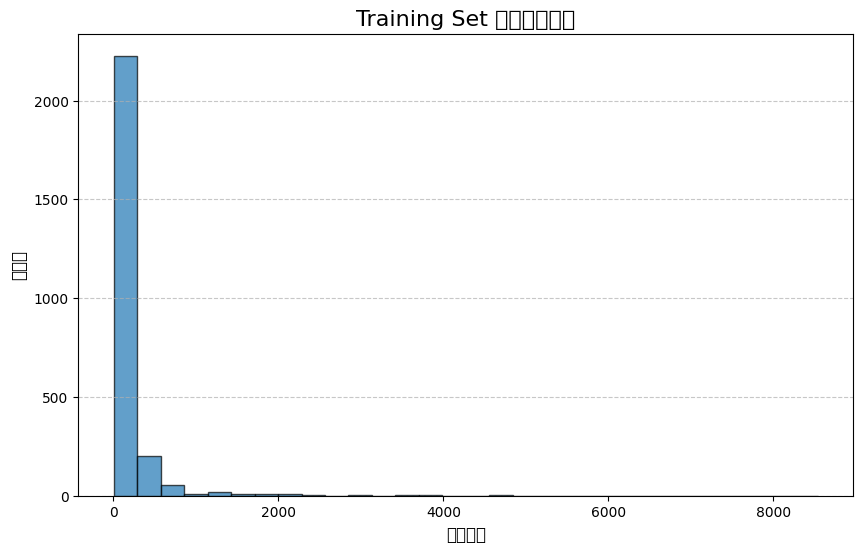


--- Training Set 標籤分佈 ---
0    1592
1     961
Name: count, dtype: int64


/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20296 (\N

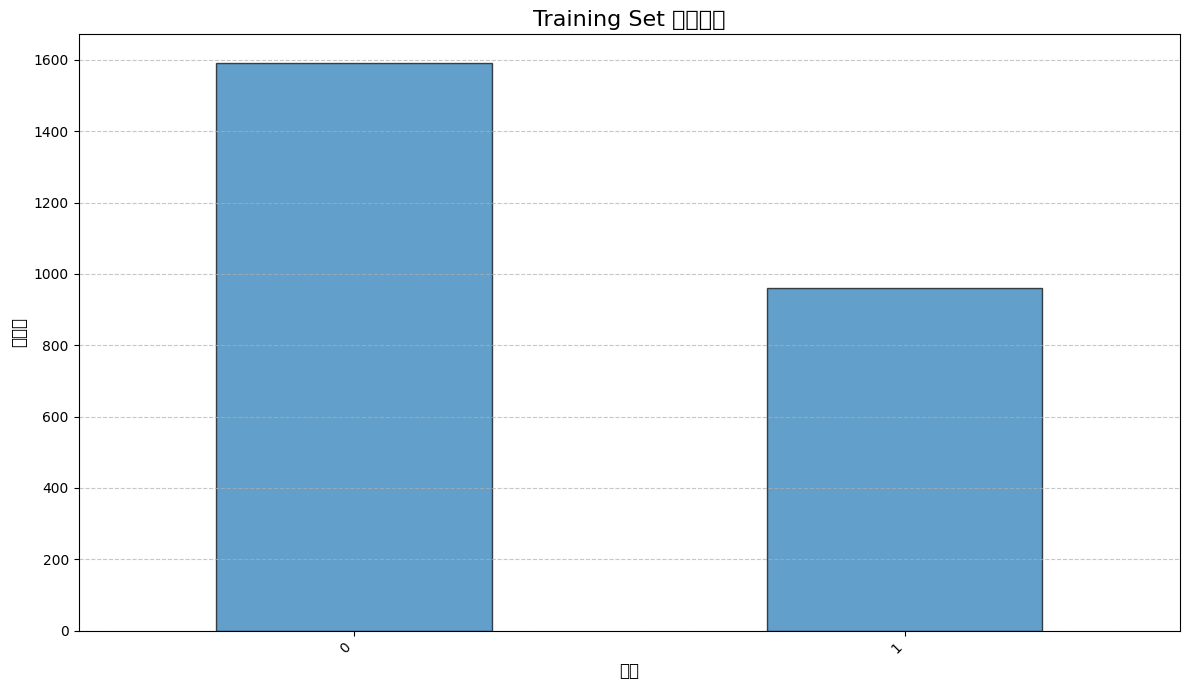


--- Validation Set 節點數量分佈 ---
圖總數: 639
平均節點數: 177.63
中位數節點數: 56.0
最大節點數: 4646
最小節點數: 1


/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31680 (\N{CJK UNIFIED IDEOGRAPH-7BC0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


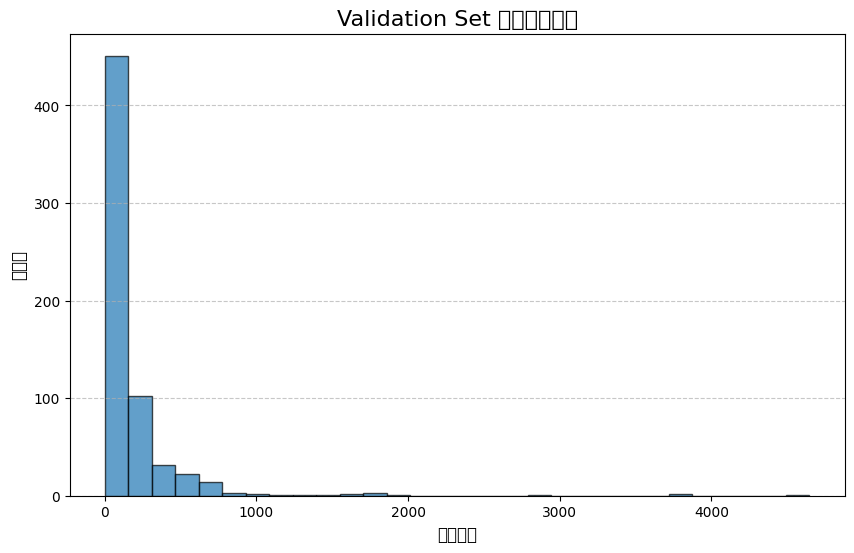


--- Validation Set 標籤分佈 ---
0    399
1    240
Name: count, dtype: int64


/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20296 (\N

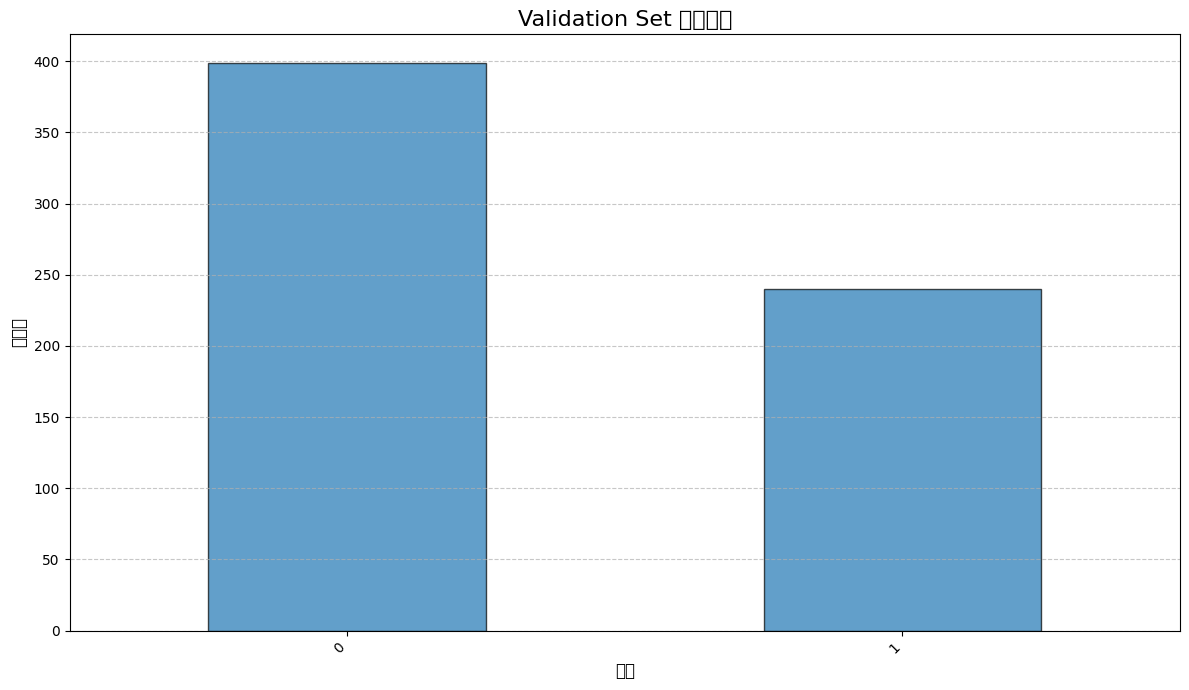


--- Test Set 節點數量分佈 ---
圖總數: 3975
平均節點數: 305.91
中位數節點數: 151.0
最大節點數: 5749
最小節點數: 1


/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31680 (\N{CJK UNIFIED IDEOGRAPH-7BC0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


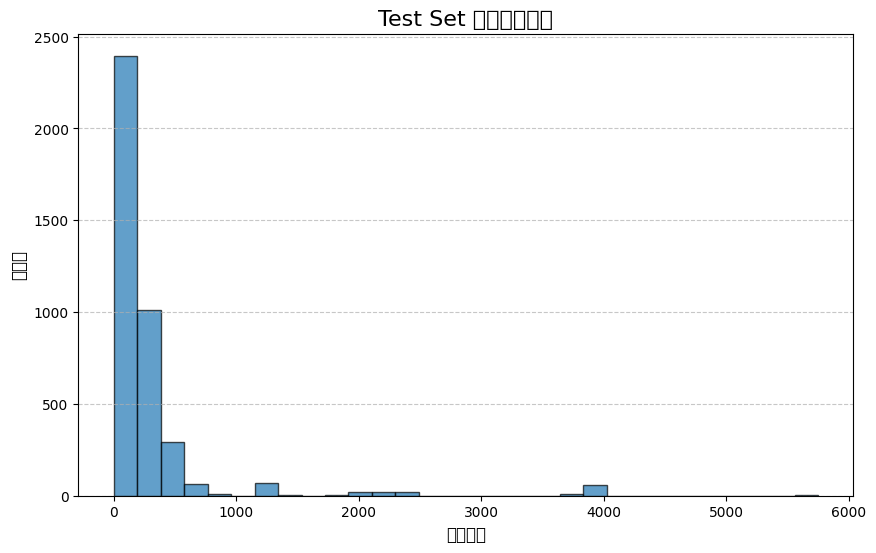


--- Test Set 標籤分佈 ---
0    2000
1    1975
Name: count, dtype: int64


/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486402/2458733074.py:197: UserWarning: Glyph 20296 (\N

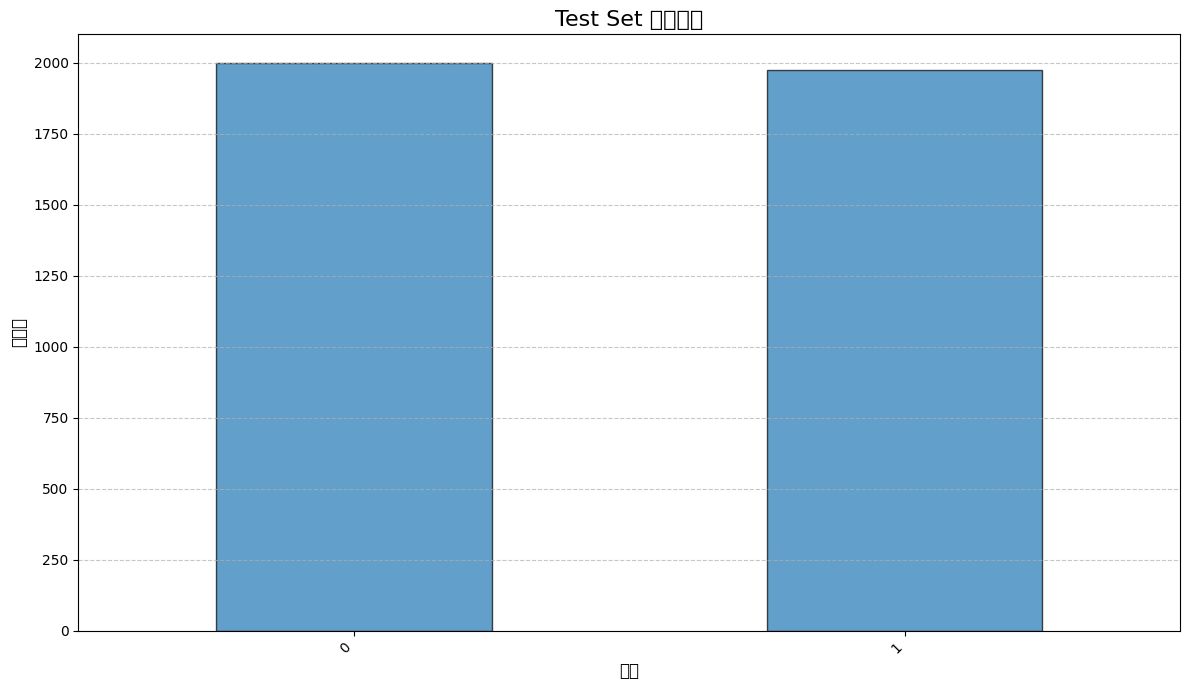

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import os
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import warnings

# 忽略 scikit-learn 的 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

def get_gnn_config():
    BASE_PATH = "/home/tommy/Project/PcodeBERT"
    
    config = {
        "source_cpus": ["AMD X86-64"],     
        "target_cpus": ["ARM-32"],        
        
        "csv_path": f"{BASE_PATH}/dataset/csv/base_dataset_filtered_v2.csv",
        "graph_dir": f"{BASE_PATH}/outputs/embeddings",
        "cache_file": f"{BASE_PATH}/outputs/cache/gnn_data_by_family_label.pkl",
        "model_output_dir": f"{BASE_PATH}/outputs/models/gnn",
        
        "batch_size": 32,
        "hidden_channels": 64,
        "learning_rate": 0.01,
        "epochs": 200,
        "patience": 20,
        
        "seeds": [42, 123, 2025, 31415, 8888],
        "device": "cuda"
    }
    
    return config

def load_graphs_from_df(df, graph_dir, label_col='label'):
    """
    從 DataFrame 載入圖資料。
    新增了 label_col 參數來決定使用哪一欄作為標籤。
    """
    graphs = []
    labels = []
    
    for _, row in df.iterrows():
        file_name = row['file_name']
        prefix = file_name[:2]
        label = row[label_col]
        graph_path = Path(graph_dir) / prefix / f"{file_name}.gpickle"

        if not graph_path.exists():
            continue
            
        with open(graph_path, 'rb') as f:
            data = pickle.load(f)
        
        node_embeddings = data['node_embeddings']
        if not node_embeddings:
            continue
        
        embeddings = [list(emb) for emb in node_embeddings.values()]
        x = torch.tensor(embeddings, dtype=torch.float)
        
        num_nodes = len(embeddings)
        edge_list = []
        for i in range(num_nodes - 1):
            edge_list.extend([[i, i+1], [i+1, i]])
        
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t()
        else:
            edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        graph_data = Data(x=x, edge_index=edge_index)
        graphs.append(graph_data)
        labels.append(label)
    
    return graphs, labels

def load_cross_arch_data_with_family_label(csv_path, graph_dir, source_cpus, target_cpus, cache_file, val_size=0.2, random_state=42, force_reload=False):
    """
    載入跨架構的圖資料，並以 'family' 作為標籤。
    """
    if force_reload and os.path.exists(cache_file):
        os.remove(cache_file)
    
    if os.path.exists(cache_file):
        print(f"Loading cached data from: {cache_file}")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
        return (cached_data['train_graphs'], 
                cached_data['val_graphs'],
                cached_data['test_graphs'], 
                cached_data['label_encoder'], 
                cached_data['num_classes'])
    
    print("Loading CSV data...")
    df = pd.read_csv(csv_path)
    
    train_df = df[df['CPU'].isin(source_cpus)]
    test_df = df[df['CPU'].isin(target_cpus)]
    
    print(f"Training data: {len(train_df)} samples (architectures: {source_cpus})")
    print(f"Test data: {len(test_df)} samples (architectures: {target_cpus})")
    
    train_graphs, train_labels = load_graphs_from_df(train_df, graph_dir, label_col='family')
    test_graphs, test_labels = load_graphs_from_df(test_df, graph_dir, label_col='family')
    
    train_graphs, val_graphs, train_labels, val_labels = train_test_split(
        train_graphs, train_labels, test_size=val_size, 
        stratify=train_labels, random_state=random_state
    )
    
    label_encoder = LabelEncoder()
    all_labels = train_labels + val_labels + test_labels
    label_encoder.fit(all_labels)
    
    encoded_train_labels = label_encoder.transform(train_labels)
    encoded_val_labels = label_encoder.transform(val_labels)
    encoded_test_labels = label_encoder.transform(test_labels)
    
    num_classes = len(label_encoder.classes_)
    
    for i, data in enumerate(train_graphs):
        data.y = torch.tensor(encoded_train_labels[i], dtype=torch.long)
        
    for i, data in enumerate(val_graphs):
        data.y = torch.tensor(encoded_val_labels[i], dtype=torch.long)
        
    for i, data in enumerate(test_graphs):
        data.y = torch.tensor(encoded_test_labels[i], dtype=torch.long)

    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    cache_data = {
        'train_graphs': train_graphs,
        'val_graphs': val_graphs,
        'test_graphs': test_graphs,
        'label_encoder': label_encoder,
        'num_classes': num_classes
    }
    
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"Data has been cached to: {cache_file}")
    return train_graphs, val_graphs, test_graphs, label_encoder, num_classes

def analyze_dataset_by_family(graphs, label_encoder):
    """
    Analyzes the node distribution for each family and returns a dictionary of stats.
    """
    family_stats = {}
    if not graphs:
        return family_stats

    # Group graphs by family
    family_groups = defaultdict(list)
    for g in graphs:
        family = label_encoder.inverse_transform([int(g.y)])[0]
        family_groups[family].append(g.num_nodes)

    for family, node_counts in family_groups.items():
        family_stats[family] = {
            "Total Graphs": len(node_counts),
            "Avg Nodes": np.mean(node_counts),
            "Median Nodes": np.median(node_counts),
            "Max Nodes": np.max(node_counts),
            "Min Nodes": np.min(node_counts)
        }
    return family_stats

def compare_datasets(train_graphs, val_graphs, test_graphs, label_encoder):
    """
    Compares key statistics of training, validation, and test datasets.
    """
    # First, print the overall comparison report
    train_stats = analyze_dataset_by_family(train_graphs, label_encoder)
    test_stats = analyze_dataset_by_family(test_graphs, label_encoder)

    all_families = sorted(list(set(train_stats.keys()) | set(test_stats.keys())))

    print("\n" + "="*50)
    print("Family-wise Node Count Comparison")
    print("="*50)

    for family in all_families:
        train_data = train_stats.get(family, {"Total Graphs": 0, "Avg Nodes": 0, "Median Nodes": 0, "Max Nodes": 0, "Min Nodes": 0})
        test_data = test_stats.get(family, {"Total Graphs": 0, "Avg Nodes": 0, "Median Nodes": 0, "Max Nodes": 0, "Min Nodes": 0})
        
        print(f"\n--- Family: {family} ---")
        
        comparison_df = pd.DataFrame({
            "Metric": ["Total Graphs", "Avg Nodes", "Median Nodes", "Max Nodes", "Min Nodes"],
            "Training Set": [train_data["Total Graphs"], f"{train_data['Avg Nodes']:.2f}", train_data["Median Nodes"], train_data["Max Nodes"], train_data["Min Nodes"]],
            "Test Set": [test_data["Total Graphs"], f"{test_data['Avg Nodes']:.2f}", test_data["Median Nodes"], test_data["Max Nodes"], test_data["Min Nodes"]]
        })
        print(comparison_df.to_string(index=False))

# Main execution
if __name__ == "__main__":
    gnn_config = get_gnn_config()
    
    train_graphs, val_graphs, test_graphs, label_encoder, num_classes = load_cross_arch_data_with_family_label(
        csv_path=gnn_config["csv_path"],
        graph_dir=gnn_config["graph_dir"],
        source_cpus=gnn_config["source_cpus"],
        target_cpus=gnn_config["target_cpus"],
        cache_file=gnn_config["cache_file"],
        force_reload=False
    )

    compare_datasets(train_graphs, val_graphs, test_graphs, label_encoder)